In [1]:
# CELL 1: SETUP & STORAGE
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Configuration
# Change 'GenAI_Project' to whatever you want the folder named in your Drive
PROJECT_NAME = "GenAI_Interpolation_Project"
PROJECT_ROOT = os.path.join("/content/drive/MyDrive", PROJECT_NAME)

# 3. Define Sub-directories
DIRS = {
    "images": os.path.join(PROJECT_ROOT, "output_images"),
    "videos": os.path.join(PROJECT_ROOT, "output_videos"),
    "logs": os.path.join(PROJECT_ROOT, "logs") # For metadata/JSON
}

# 4. Create Directories
print(f"🚀 Initializing Project at: {PROJECT_ROOT}")
for key, path in DIRS.items():
    os.makedirs(path, exist_ok=True)
    print(f"   📂 {key.capitalize()} folder ready: {path}")

print("✅ Storage Setup Complete.")

Mounted at /content/drive
🚀 Initializing Project at: /content/drive/MyDrive/GenAI_Interpolation_Project
   📂 Images folder ready: /content/drive/MyDrive/GenAI_Interpolation_Project/output_images
   📂 Videos folder ready: /content/drive/MyDrive/GenAI_Interpolation_Project/output_videos
   📂 Logs folder ready: /content/drive/MyDrive/GenAI_Interpolation_Project/logs
✅ Storage Setup Complete.


In [2]:
# CELL 2: INSTALL LIBRARIES
# Quietly install dependencies to keep logs clean
print("⏳ Installing libraries... (This may take 1-2 minutes)")
!pip install -q diffusers transformers accelerate scipy safetensors opencv-python lpips

print("✅ Installation Complete.")

⏳ Installing libraries... (This may take 1-2 minutes)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.2 MB/s eta 0:00:00
✅ Installation Complete.


In [3]:
# CELL 3: IMPORTS & UTILS
import torch
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import StableDiffusionPipeline, StableDiffusionXLPipeline

# 1. Hardware Check
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"⚡ Hardware Status: {device.upper()}")
if device == "cpu":
    print("⚠️ WARNING: You are running on CPU. Generation will be extremely slow.")
    print("👉 Go to Runtime > Change runtime type > T4 GPU")

# 2. Helper: Save Metadata (Checkpointing)
def save_metadata(filename, prompt_a, prompt_b, method, model_name, seed):
    """Saves a JSON file alongside the image/video with generation details."""
    meta_path = os.path.join(DIRS["logs"], f"{filename}.json")
    data = {
        "prompt_start": prompt_a,
        "prompt_end": prompt_b,
        "interpolation_method": method,
        "model": model_name,
        "seed": seed
    }
    with open(meta_path, 'w') as f:
        json.dump(data, f, indent=4)
    return meta_path

# 3. Helper: Display Image
def show_image(img, title="Generated Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(title)
    plt.show()

⚡ Hardware Status: CUDA


In [4]:
# CELL 4: LOAD MODELS

# --- Load Stable Diffusion v1.5 ---
print("⏳ Loading SD v1.5...")
pipe_v15 = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    use_safetensors=True
)
pipe_v15 = pipe_v15.to(device)
print("✅ SD v1.5 Ready.")

# --- Load Stable Diffusion XL ---
print("⏳ Loading SDXL Base 1.0...")
pipe_sdxl = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
)

# CRITICAL OPTIMIZATIONS FOR COLAB FREE TIER
# 1. Offload UNet/Text Encoder to CPU when not used to save VRAM
pipe_sdxl.enable_model_cpu_offload()
# 2. Slice VAE decoding to prevent OOM errors
pipe_sdxl.enable_vae_slicing()

print("✅ SDXL Ready (Optimized).")

⏳ Loading SD v1.5...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


✅ SD v1.5 Ready.
⏳ Loading SDXL Base 1.0...


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 19 files:   0%|          | 0/19 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

vae_1_0/diffusion_pytorch_model.fp16.saf(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ SDXL Ready (Optimized).


🧪 Testing generation with prompt: 'A futuristic laboratory with glowing blue lights, cyberpunk'
   ...Running SD v1.5


  0%|          | 0/50 [00:00<?, ?it/s]

   ...Running SDXL (This takes longer)


  0%|          | 0/50 [00:00<?, ?it/s]


RESULTS:
1. SD v1.5 Image saved to: /content/drive/MyDrive/GenAI_Interpolation_Project/output_images/test_run_v15.png
2. SDXL Image saved to:    /content/drive/MyDrive/GenAI_Interpolation_Project/output_images/test_run_sdxl.png
PLEASE CHECK YOUR GOOGLE DRIVE FOLDER NOW TO VERIFY FILES EXIST.


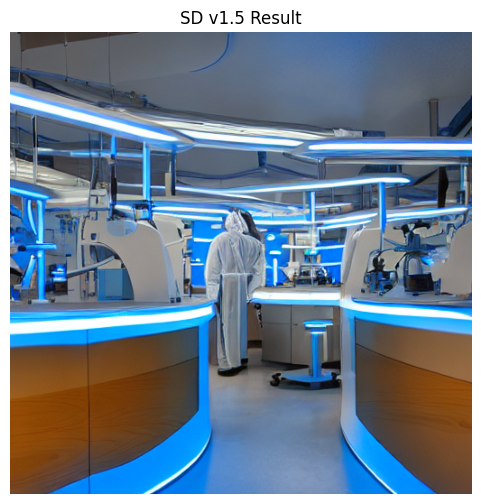

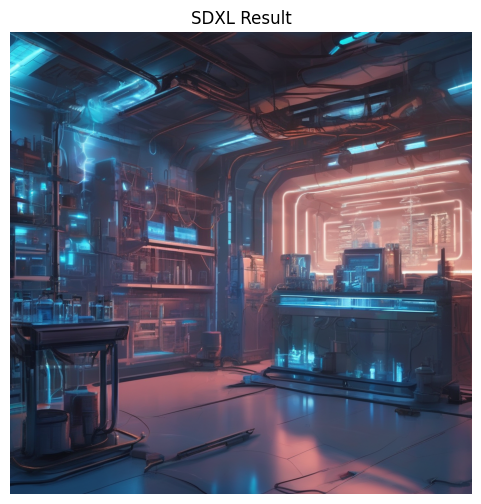

In [ ]:
# CELL 5: SYSTEM TEST & SAVING CHECK

test_prompt = "A futuristic laboratory with glowing blue lights, cyberpunk"
test_seed = 42
generator = torch.Generator(device).manual_seed(test_seed)

print(f"🧪 Testing generation with prompt: '{test_prompt}'")

# --- Test 1: SD v1.5 ---
print("   ...Running SD v1.5")
image_v15 = pipe_v15(test_prompt, generator=generator).images[0]
filename_v15 = "test_run_v15"

# Save Image to Drive
save_path_v15 = os.path.join(DIRS["images"], f"{filename_v15}.png")
image_v15.save(save_path_v15)

# Save Metadata to Drive
save_metadata(filename_v15, test_prompt, "N/A", "Test", "SD 1.5", test_seed)

# --- Test 2: SDXL ---
print("   ...Running SDXL (This takes longer)")
image_xl = pipe_sdxl(test_prompt, generator=generator).images[0]
filename_xl = "test_run_sdxl"

# Save Image to Drive
save_path_xl = os.path.join(DIRS["images"], f"{filename_xl}.png")
image_xl.save(save_path_xl)

# Save Metadata to Drive
save_metadata(filename_xl, test_prompt, "N/A", "Test", "SDXL", test_seed)

# --- Verification ---
print("\n" + "="*40)
print("RESULTS:")
print(f"1. SD v1.5 Image saved to: {save_path_v15}")
print(f"2. SDXL Image saved to:    {save_path_xl}")
print("="*40)
print("PLEASE CHECK YOUR GOOGLE DRIVE FOLDER NOW TO VERIFY FILES EXIST.")

# Show results
show_image(image_v15, "SD v1.5 Result")
show_image(image_xl, "SDXL Result")

In [7]:
# CELL 6: MATH FUNCTIONS (Lerp & Slerp)

def lerp(v0, v1, t):
    """Linear Interpolation: Straight line between points."""
    return (1 - t) * v0 + t * v1

def slerp(v0, v1, t, DOT_THRESHOLD=0.9995):
    """Spherical Linear Interpolation: Arced path on a hypersphere."""
    # 1. Inputs are tensors (Batch, Channels, Height, Width)
    # We must flatten them to calculate the angle (dot product)
    v0_flat = v0.flatten()
    v1_flat = v1.flatten()

    # 2. Normalize vectors to unit length
    v0_norm = v0_flat / torch.norm(v0_flat)
    v1_norm = v1_flat / torch.norm(v1_flat)

    # 3. Calculate Dot Product (Cosine of angle)
    dot = torch.sum(v0_norm * v1_norm)

    # 4. Handle floating point errors (clamp to -1, 1)
    dot = torch.clamp(dot, -1.0, 1.0)

    # 5. If vectors are too close (parallel), just use Lerp
    # (Avoids division by zero errors)
    if torch.abs(dot) > DOT_THRESHOLD:
        return lerp(v0, v1, t)

    # 6. Calculate Omega (Total Angle)
    omega = torch.acos(dot)
    sin_omega = torch.sin(omega)

    # 7. Slerp Formula
    scale_0 = torch.sin((1 - t) * omega) / sin_omega
    scale_1 = torch.sin(t * omega) / sin_omega

    return scale_0 * v0 + scale_1 * v1

print("✅ Math functions (Lerp/Slerp) defined.")

✅ Math functions (Lerp/Slerp) defined.


In [8]:
# CELL 7: LATENT & EMBEDDING PREPARATION

def get_latents_and_embeddings(pipe, prompt1, prompt2, seed, model_type="v15"):
    """
    Generates the starting and ending vectors (Noise + Text Embeddings).
    """
    generator = torch.Generator(device).manual_seed(seed)

    # --- 1. Generate Noise (The Visual Chaos) ---
    # SD 1.5 uses 4 channels, 64x64 resolution (512px image)
    # SDXL uses 4 channels, 128x128 resolution (1024px image)
    height = 1024 if model_type == "sdxl" else 512
    width = 1024 if model_type == "sdxl" else 512

    # Standard latent shape for diffusion models
    # (Batch=1, Channels=4, Height/8, Width/8)
    shape = (1, 4, height // 8, width // 8)

    # We generate two DIFFERENT noise patterns (Seed, Seed+1)
    # This forces the video to morph structure, not just content.
    rand_noise_start = torch.randn(shape, generator=generator, device=device, dtype=torch.float16)
    rand_noise_end = torch.randn(shape, generator=torch.Generator(device).manual_seed(seed+1), device=device, dtype=torch.float16)

    # --- 2. Encode Text (The Semantic Meaning) ---
    if model_type == "sdxl":
        # SDXL returns 4 items. We need the first (embeds) and third (pooled)
        # We assume no negative prompt for simplicity in this experiment
        (embeds_start, _, pooled_start, _) = pipe.encode_prompt(prompt1, device=device, do_classifier_free_guidance=False)
        (embeds_end, _, pooled_end, _) = pipe.encode_prompt(prompt2, device=device, do_classifier_free_guidance=False)
        return (rand_noise_start, rand_noise_end), (embeds_start, embeds_end), (pooled_start, pooled_end)

    else: # SD v1.5
        embeds_start = pipe.encode_prompt(prompt1, device=device, num_images_per_prompt=1, do_classifier_free_guidance=False)[0]
        embeds_end = pipe.encode_prompt(prompt2, device=device, num_images_per_prompt=1, do_classifier_free_guidance=False)[0]
        # v1.5 doesn't use pooled embeddings, so we return None
        return (rand_noise_start, rand_noise_end), (embeds_start, embeds_end), None

print("✅ Feature Extraction logic defined.")

✅ Feature Extraction logic defined.


In [11]:
# CELL 8: INTERPOLATION LOOP & VIDEO SAVER
import cv2

def generate_video(
    pipe,
    prompt_start,
    prompt_end,
    method="slerp",
    steps=30,
    seed=42,
    model_name="v15"
):
    print(f"🎬 Starting Video: {prompt_start} -> {prompt_end} | Method: {method.upper()} | Model: {model_name}")

    # 1. Get Start/End Tensors
    (noise_pair, emb_pair, pooled_pair) = get_latents_and_embeddings(
        pipe, prompt_start, prompt_end, seed, model_type="sdxl" if "xl" in model_name.lower() else "v15"
    )

    frames = []

    # 2. The Interpolation Loop
    for i in range(steps):
        t = i / (steps - 1) # Goes from 0.0 to 1.0

        # A. Interpolate Text Embeddings (Always Lerp for Text)
        current_emb = lerp(emb_pair[0], emb_pair[1], t)

        # Handle SDXL Pooled Embeddings
        current_pooled = None
        if pooled_pair is not None:
             current_pooled = lerp(pooled_pair[0], pooled_pair[1], t)

        # B. Interpolate Noise (Lerp or Slerp)
        if method == "slerp":
            current_noise = slerp(noise_pair[0], noise_pair[1], t)
        else:
            current_noise = lerp(noise_pair[0], noise_pair[1], t)

        # C. Generate Image
        # We pass the interpolated noise as 'latents'
        if "xl" in model_name.lower():
            image = pipe(
                prompt_embeds=current_emb,
                pooled_prompt_embeds=current_pooled,
                latents=current_noise,
                guidance_scale=7.5,
                num_inference_steps=25 # Lower steps for speed (standard is 50)
            ).images[0]
        else:
            image = pipe(
                prompt_embeds=current_emb,
                latents=current_noise,
                guidance_scale=7.5,
                num_inference_steps=25
            ).images[0]

        frames.append(np.array(image))
        print(f"   Frame {i+1}/{steps} generated.", end='\r')

    # 3. Save Video using OpenCV
    filename = f"{model_name}_{method}_{prompt_start[:10].replace(' ','')}_to_{prompt_end[:10].replace(' ','')}.mp4"
    save_path = os.path.join(DIRS["videos"], filename)

    # Setup Video Writer
    height, width, layers = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Codec
    video = cv2.VideoWriter(save_path, fourcc, 10, (width, height)) # 10 FPS

    for frame in frames:
        video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)) # Convert RGB to BGR for OpenCV

    video.release()
    print(f"\n✅ Video Saved: {save_path}")

    # Save Metadata
    save_metadata(filename, prompt_start, prompt_end, method, model_name, seed)
    return save_path

print("✅ Video Generation Pipeline defined.")

✅ Video Generation Pipeline defined.


In [ ]:
# CELL 9: TEST RUN (PHASE 2 CHECK)

# Simple prompts
p1 = "A red apple on a table"
p2 = "A green pear on a table"

# 1. Test SD v1.5 with Lerp
generate_video(pipe_v15, p1, p2, method="lerp", steps=10, seed=100, model_name="v15")

# 2. Test SD v1.5 with Slerp
generate_video(pipe_v15, p1, p2, method="slerp", steps=10, seed=100, model_name="v15")

print("Check your 'output_videos' folder in Drive. If you see two MP4s, Phase 2 is DONE.")

🎬 Starting Video: A red apple on a table -> A green pear on a table | Method: LERP | Model: v15


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

   Frame 10/10 generated.
✅ Video Saved: /content/drive/MyDrive/GenAI_Interpolation_Project/output_videos/v15_lerp_Aredappl_to_Agreenpe.mp4
🎬 Starting Video: A red apple on a table -> A green pear on a table | Method: SLERP | Model: v15


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

   Frame 10/10 generated.
✅ Video Saved: /content/drive/MyDrive/GenAI_Interpolation_Project/output_videos/v15_slerp_Aredappl_to_Agreenpe.mp4
Check your 'output_videos' folder in Drive. If you see two MP4s, Phase 2 is DONE.


In [5]:
# CELL 10: SMART BATCH RUN (RESUME CAPABLE)

# 1. Define the Dataset
EXPERIMENTS = {
    "Similar": [
        ("A photo of a golden retriever dog", "A photo of a german shepherd dog"),
        ("A red sports car on a road", "A blue sedan on a road")
    ],
    "Dissimilar": [
        ("A medieval stone castle on a hill", "A futuristic sci-fi spaceship in orbit"),
        ("A bowl of fresh fruit on a table", "A busy new york city skyline")
    ],
    "Style": [
        ("A portrait of a woman, photorealistic 8k", "A portrait of a woman, cubist painting by picasso"),
        ("A landscape of a mountain, oil painting", "A landscape of a mountain, pencil sketch")
    ]
}

STEPS = 30
SEED = 2025

print("🚀 RESUMING EXPERIMENTAL RUN...")

for category, pairs in EXPERIMENTS.items():
    print(f"\n📂 CATEGORY: {category}")

    for (p_start, p_end) in pairs:
        # Construct expected filenames to check existence
        # Note: We must match the naming convention in generate_video function
        clean_start = p_start[:10].replace(' ','')
        clean_end = p_end[:10].replace(' ','')

        # --- MODEL 1: SD v1.5 ---
        for method in ["lerp", "slerp"]:
            filename = f"v15_{method}_{clean_start}_to_{clean_end}.mp4"
            filepath = os.path.join(DIRS["videos"], filename)

            if os.path.exists(filepath):
                print(f"   ✅ Found {filename} - SKIPPING")
            else:
                try:
                    generate_video(pipe_v15, p_start, p_end, method, steps=STEPS, seed=SEED, model_name="v15")
                except Exception as e:
                    print(f"   ❌ Error v15 {method}: {e}")

        # --- MODEL 2: SDXL ---
        for method in ["lerp", "slerp"]:
            filename = f"sdxl_{method}_{clean_start}_to_{clean_end}.mp4"
            filepath = os.path.join(DIRS["videos"], filename)

            if os.path.exists(filepath):
                print(f"   ✅ Found {filename} - SKIPPING")
            else:
                try:
                    print(f"   ⏳ Generating SDXL {method} (This takes ~10 mins)...")
                    generate_video(pipe_sdxl, p_start, p_end, method, steps=STEPS, seed=SEED, model_name="sdxl")
                except Exception as e:
                    print(f"   ❌ Error SDXL {method}: {e}")

print("\n🎉 BATCH CHECK COMPLETE.")

🚀 RESUMING EXPERIMENTAL RUN...

📂 CATEGORY: Similar
   ✅ Found v15_lerp_Aphotoof_to_Aphotoof.mp4 - SKIPPING
   ✅ Found v15_slerp_Aphotoof_to_Aphotoof.mp4 - SKIPPING
   ✅ Found sdxl_lerp_Aphotoof_to_Aphotoof.mp4 - SKIPPING
   ✅ Found sdxl_slerp_Aphotoof_to_Aphotoof.mp4 - SKIPPING
   ✅ Found v15_lerp_Aredspor_to_Abluesed.mp4 - SKIPPING
   ✅ Found v15_slerp_Aredspor_to_Abluesed.mp4 - SKIPPING
   ✅ Found sdxl_lerp_Aredspor_to_Abluesed.mp4 - SKIPPING
   ✅ Found sdxl_slerp_Aredspor_to_Abluesed.mp4 - SKIPPING

📂 CATEGORY: Dissimilar
   ✅ Found v15_lerp_Amedieval_to_Afuturist.mp4 - SKIPPING
   ✅ Found v15_slerp_Amedieval_to_Afuturist.mp4 - SKIPPING
   ✅ Found sdxl_lerp_Amedieval_to_Afuturist.mp4 - SKIPPING
   ✅ Found sdxl_slerp_Amedieval_to_Afuturist.mp4 - SKIPPING
   ✅ Found v15_lerp_Abowlof_to_Abusynew.mp4 - SKIPPING
   ✅ Found v15_slerp_Abowlof_to_Abusynew.mp4 - SKIPPING
   ✅ Found sdxl_lerp_Abowlof_to_Abusynew.mp4 - SKIPPING
   ✅ Found sdxl_slerp_Abowlof_to_Abusynew.mp4 - SKIPPING

📂 CATEG

In [ ]:
# CELL 10.5: FIX DEPENDENCIES (Downgrade to Classic)
print("⏳ Downgrading to MoviePy 1.0.3...")

# 1. Uninstall the broken "New" versions
!pip uninstall -y moviepy imageio

# 2. Install the "Classic" stable versions
!pip install moviepy==1.0.3 imageio==2.9.0 imageio-ffmpeg

print("✅ Fix Complete. PLEASE RESTART SESSION NOW.")

⏳ Downgrading to MoviePy 1.0.3...
Found existing installation: moviepy 2.2.1
Uninstalling moviepy-2.2.1:
  Successfully uninstalled moviepy-2.2.1
Found existing installation: ImageIO 2.37.2
Uninstalling ImageIO-2.37.2:
  Successfully uninstalled ImageIO-2.37.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 10.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 92.4 MB/s eta 0:00:00
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110712 sha256=917304b2ecee945d8e1d01e0e2465b01f89b0d89035194b9c22a852a77e5efc9
  Stored in directory: /root/.cache/pip/wheels/df/ba/4b/0917fc0c8833c8ba7016565fc975b74c67bc8610806e930272
Successfully built moviepy
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.25.2 requires imageio!=2.35.0,>=2.33, but you have imageio 2.9.

✅ Fix Complete. PLEASE RESTART SESSION NOW.


In [ ]:
# CELL 11: GENERATE COMPARISON GRIDS (Run after Restart)

import os
import sys
from moviepy.editor import VideoFileClip, clips_array

# 1. Define Directories (Since variables are lost after restart)
PROJECT_ROOT = "/content/drive/MyDrive/GenAI_Interpolation_Project"
DIRS = {"videos": os.path.join(PROJECT_ROOT, "output_videos")}
OUTPUT_GRIDS = os.path.join(PROJECT_ROOT, "comparison_grids")
os.makedirs(OUTPUT_GRIDS, exist_ok=True)

# 2. Define Experiments
EXPERIMENTS = {
    "Similar": [
        ("A photo of a golden retriever dog", "A photo of a german shepherd dog"),
        ("A red sports car on a road", "A blue sedan on a road")
    ],
    "Dissimilar": [
        ("A medieval stone castle on a hill", "A futuristic sci-fi spaceship in orbit"),
        ("A bowl of fresh fruit on a table", "A busy new york city skyline")
    ],
    "Style": [
        ("A portrait of a woman, photorealistic 8k", "A portrait of a woman, cubist painting by picasso"),
        ("A landscape of a mountain, oil painting", "A landscape of a mountain, pencil sketch")
    ]
}

print(f"🚀 STARTING GRID GENERATION...")

def get_video_path(model, method, p_start, p_end):
    clean_start = p_start[:10].replace(' ','')
    clean_end = p_end[:10].replace(' ','')
    filename = f"{model}_{method}_{clean_start}_to_{clean_end}.mp4"
    return os.path.join(DIRS["videos"], filename)

for category, pairs in EXPERIMENTS.items():
    print(f"\n📂 Processing Category: {category}")

    for (p_start, p_end) in pairs:
        print(f"   🔹 Stitching: {p_start[:15]}...")

        # Locate files
        files = [
            get_video_path("v15", "lerp", p_start, p_end),
            get_video_path("v15", "slerp", p_start, p_end),
            get_video_path("sdxl", "lerp", p_start, p_end),
            get_video_path("sdxl", "slerp", p_start, p_end)
        ]

        if all(os.path.exists(p) for p in files):
            try:
                # Load Clips
                c1 = VideoFileClip(files[0]).margin(4, color=(255,255,255))
                c2 = VideoFileClip(files[1]).margin(4, color=(255,255,255))

                # Resize SDXL (clips 3 and 4) to match SD1.5 height
                c3 = VideoFileClip(files[2]).resize(height=c1.h).margin(4, color=(255,255,255))
                c4 = VideoFileClip(files[3]).resize(height=c1.h).margin(4, color=(255,255,255))

                # Array: [[v15L, v15S], [XLL, XLS]]
                final = clips_array([[c1, c2], [c3, c4]])

                save_name = f"GRID_{category}_{p_start[:5].replace(' ','')}.mp4"
                save_path = os.path.join(OUTPUT_GRIDS, save_name)

                final.write_videofile(save_path, fps=10, codec="libx264", audio=False, verbose=False, logger=None)
                print(f"      ✅ Saved: {save_name}")

                # Close files to free memory
                for c in [c1, c2, c3, c4, final]: c.close()

            except Exception as e:
                print(f"      ❌ Error: {e}")
        else:
            print("      ⚠️ Missing files. Skipping.")

print("\n🎉 ALL GRIDS COMPLETE. Check 'comparison_grids' folder.")

🚀 STARTING GRID GENERATION...

📂 Processing Category: Similar
   🔹 Stitching: A photo of a go...
      ✅ Saved: GRID_Similar_Apho.mp4
   🔹 Stitching: A red sports ca...
      ✅ Saved: GRID_Similar_Ared.mp4

📂 Processing Category: Dissimilar
   🔹 Stitching: A medieval ston...
      ✅ Saved: GRID_Dissimilar_Amed.mp4
   🔹 Stitching: A bowl of fresh...
      ✅ Saved: GRID_Dissimilar_Abow.mp4

📂 Processing Category: Style
   🔹 Stitching: A portrait of a...
      ✅ Saved: GRID_Style_Apor.mp4
   🔹 Stitching: A landscape of ...
      ✅ Saved: GRID_Style_Alan.mp4

🎉 ALL GRIDS COMPLETE. Check 'comparison_grids' folder.


In [ ]:
# CELL 12: QUANTITATIVE ANALYSIS (LPIPS GRAPHS) - FIXED
import lpips
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import os

# --- 1. SETUP (Redefine variables lost during restart) ---
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"⚡ Using device: {device.upper()}")

# Define Paths
PROJECT_ROOT = "/content/drive/MyDrive/GenAI_Interpolation_Project"
DIRS = {"videos": os.path.join(PROJECT_ROOT, "output_videos")}
OUTPUT_GRAPHS = os.path.join(PROJECT_ROOT, "analysis_graphs")
os.makedirs(OUTPUT_GRAPHS, exist_ok=True)

# Define Experiments
EXPERIMENTS = {
    "Similar": [
        ("A photo of a golden retriever dog", "A photo of a german shepherd dog"),
        ("A red sports car on a road", "A blue sedan on a road")
    ],
    "Dissimilar": [
        ("A medieval stone castle on a hill", "A futuristic sci-fi spaceship in orbit"),
        ("A bowl of fresh fruit on a table", "A busy new york city skyline")
    ],
    "Style": [
        ("A portrait of a woman, photorealistic 8k", "A portrait of a woman, cubist painting by picasso"),
        ("A landscape of a mountain, oil painting", "A landscape of a mountain, pencil sketch")
    ]
}
# ---------------------------------------------------------

# 2. Setup LPIPS Model (AlexNet backbone is standard for this)
print("⏳ Loading LPIPS Metric...")
loss_fn = lpips.LPIPS(net='alex').to(device)

def get_smoothness_curve(video_path):
    """Calculates LPIPS distance between frame t and t+1."""
    cap = cv2.VideoCapture(video_path)
    frames = []
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        # Convert BGR to RGB and Normalize to [-1, 1] for LPIPS
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frame = (frame / 127.5) - 1.0
        frames.append(torch.from_numpy(frame).permute(2, 0, 1).float())
    cap.release()

    # Calculate distances
    dists = []
    if len(frames) < 2: return [0]

    # Stack frames for batch processing (faster)
    # Process in small batches to save VRAM
    tensors = torch.stack(frames).to(device)

    with torch.no_grad():
        # Compare Frame[i] with Frame[i+1]
        for i in range(len(tensors) - 1):
            d = loss_fn(tensors[i:i+1], tensors[i+1:i+2])
            dists.append(d.item())

    return dists

# 3. Main Analysis Loop
print("🚀 STARTING LPIPS ANALYSIS...")

for category, pairs in EXPERIMENTS.items():
    print(f"\n📊 Analyzing Category: {category}")

    for (p_start, p_end) in pairs:
        print(f"   🔹 Processing: {p_start[:15]}...")

        # We need to compare Lerp vs Slerp for BOTH models
        clean_name = p_start[:5].replace(' ','')

        for model in ["v15", "sdxl"]:
            # Construct filenames matching your saved format
            clean_start = p_start[:10].replace(' ','')
            clean_end = p_end[:10].replace(' ','')

            path_lerp = os.path.join(DIRS["videos"], f"{model}_lerp_{clean_start}_to_{clean_end}.mp4")
            path_slerp = os.path.join(DIRS["videos"], f"{model}_slerp_{clean_start}_to_{clean_end}.mp4")

            if os.path.exists(path_lerp) and os.path.exists(path_slerp):
                try:
                    # Calculate Curves
                    curve_lerp = get_smoothness_curve(path_lerp)
                    curve_slerp = get_smoothness_curve(path_slerp)

                    # Plotting
                    plt.figure(figsize=(10, 5))
                    plt.plot(curve_lerp, label='Linear (Lerp)', color='red', linestyle='--', linewidth=1.5)
                    plt.plot(curve_slerp, label='Spherical (Slerp)', color='blue', linewidth=1.5)

                    plt.title(f"Transition Smoothness ({model.upper()}): {category}")
                    plt.xlabel("Frame Number (Time)")
                    plt.ylabel("Perceptual Distance (Lower is Smoother)")
                    plt.legend()
                    plt.grid(True, alpha=0.3)

                    # Save Graph
                    graph_name = f"GRAPH_{model}_{category}_{clean_name}.png"
                    plt.savefig(os.path.join(OUTPUT_GRAPHS, graph_name))
                    plt.close()
                    print(f"      ✅ Saved Graph: {graph_name}")
                except Exception as e:
                    print(f"      ❌ Error processing graph: {e}")
            else:
                print(f"      ⚠️ Missing video files for {model}. Skipping.")

print("\n🎉 ANALYSIS COMPLETE. Check 'analysis_graphs' folder.")

⚡ Using device: CUDA
⏳ Loading LPIPS Metric...
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.12/dist-packages/lpips/weights/v0.1/alex.pth
🚀 STARTING LPIPS ANALYSIS...

📊 Analyzing Category: Similar
   🔹 Processing: A photo of a go...
      ✅ Saved Graph: GRAPH_v15_Similar_Apho.png
      ✅ Saved Graph: GRAPH_sdxl_Similar_Apho.png
   🔹 Processing: A red sports ca...
      ✅ Saved Graph: GRAPH_v15_Similar_Ared.png
      ✅ Saved Graph: GRAPH_sdxl_Similar_Ared.png

📊 Analyzing Category: Dissimilar
   🔹 Processing: A medieval ston...
      ✅ Saved Graph: GRAPH_v15_Dissimilar_Amed.png
      ✅ Saved Graph: GRAPH_sdxl_Dissimilar_Amed.png
   🔹 Processing: A bowl of fresh...
      ✅ Saved Graph: GRAPH_v15_Dissimilar_Abow.png
      ✅ Saved Graph: GRAPH_sdxl_Dissimilar_Abow.png

📊 Analyzing Category: Style
   🔹 Processing: A portrait of a...
      ✅ Saved Graph: GRAPH_v15_Style_Apor.png
      ✅ Saved Graph: GRAPH_sdxl_Style_Apor.p

🚀 STARTING TRAJECTORY ANALYSIS...
   (This reduces 16,000 dimensions down to 2 dimensions to visualize the path)
   🔹 Calculating Lerp Path...
   🔹 Calculating Slerp Path...


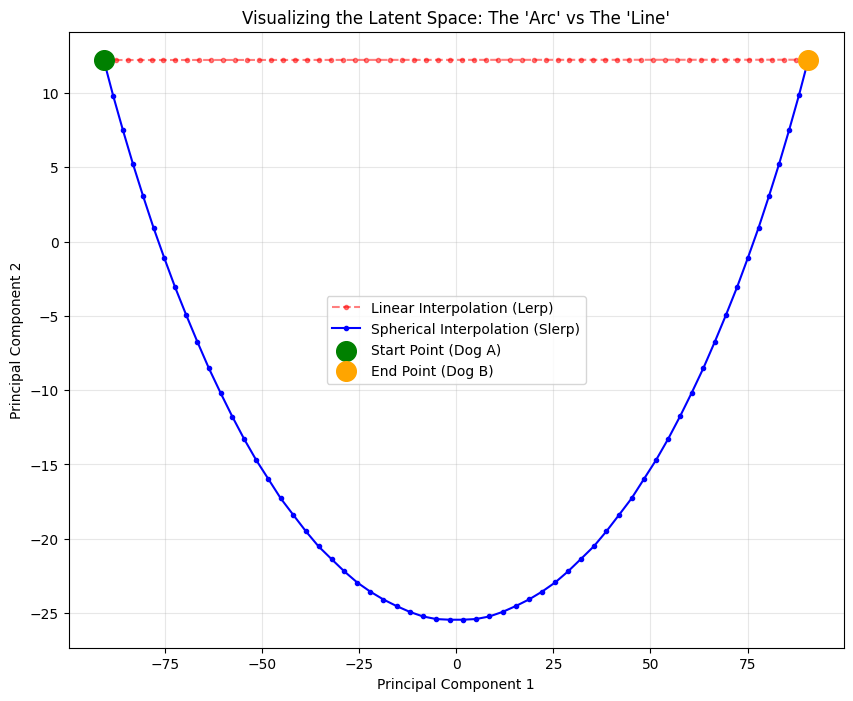

✅ Geometry Proof Saved: /content/drive/MyDrive/GenAI_Interpolation_Project/analysis_graphs/Latent_Geometry_Proof.png


In [9]:
# CELL 13: LATENT SPACE TRAJECTORY VISUALIZATION (PCA)
# This script proves the "Geometry" of the space by plotting the path of the vectors.

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import torch

# 1. Reuse your existing helper to get start/end points
def get_trajectory_points(pipe, p_start, p_end, steps, method, seed):
    # Get the endpoints
    (noise_pair, _, _) = get_latents_and_embeddings(pipe, p_start, p_end, seed, "v15")
    start_noise = noise_pair[0]
    end_noise = noise_pair[1]

    trajectory = []

    # Generate the path
    for i in range(steps):
        t = i / (steps - 1)
        if method == "slerp":
            current = slerp(start_noise, end_noise, t)
        else:
            current = lerp(start_noise, end_noise, t)

        # Flatten the tensor (1, 4, 64, 64) -> (16384,)
        # We need a 1D vector for PCA
        trajectory.append(current.cpu().numpy().flatten())

    return np.array(trajectory)

print("🚀 STARTING TRAJECTORY ANALYSIS...")
print("   (This reduces 16,000 dimensions down to 2 dimensions to visualize the path)")

# We will use one pair to demonstrate the geometry
p1 = "A photo of a golden retriever dog"
p2 = "A photo of a german shepherd dog"
STEPS = 60 # More steps = smoother curve in the plot

# 2. Generate the paths
print("   🔹 Calculating Lerp Path...")
path_lerp = get_trajectory_points(pipe_v15, p1, p2, STEPS, "lerp", 42)

print("   🔹 Calculating Slerp Path...")
path_slerp = get_trajectory_points(pipe_v15, p1, p2, STEPS, "slerp", 42)

# 3. Apply PCA
# We combine both paths so the PCA learns the 'map' of both together
combined_data = np.vstack([path_lerp, path_slerp])
pca = PCA(n_components=2) # Squash to 2D (X, Y)
pca_result = pca.fit_transform(combined_data)

# Split them back up
lerp_2d = pca_result[:STEPS]
slerp_2d = pca_result[STEPS:]

# 4. Plotting
plt.figure(figsize=(10, 8))

# Plot Lerp (Red Dotted)
plt.plot(lerp_2d[:, 0], lerp_2d[:, 1], color='red', linestyle='--', label='Linear Interpolation (Lerp)', marker='.', alpha=0.5)

# Plot Slerp (Blue Solid)
plt.plot(slerp_2d[:, 0], slerp_2d[:, 1], color='blue', label='Spherical Interpolation (Slerp)', marker='.')

# Mark Start and End
plt.scatter(lerp_2d[0, 0], lerp_2d[0, 1], color='green', s=200, label='Start Point (Dog A)', zorder=5)
plt.scatter(lerp_2d[-1, 0], lerp_2d[-1, 1], color='orange', s=200, label='End Point (Dog B)', zorder=5)

plt.title("Visualizing the Latent Space: The 'Arc' vs The 'Line'")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True, alpha=0.3)

# Save
save_path = os.path.join(PROJECT_ROOT, "analysis_graphs", "Latent_Geometry_Proof.png")
plt.savefig(save_path)
plt.show()

print(f"✅ Geometry Proof Saved: {save_path}")

In [12]:
# CELL 14: ABLATION STUDY (Essential for Bonus Marks)
# This separates the "Visual" interpolation from the "Semantic" interpolation

import cv2
import os
import numpy as np
import torch

def run_ablation_study():
    print("🔬 STARTING ABLATION STUDY (Bonus Marks)...")

    # Define a clear test case
    p1 = "A photo of a cat"
    p2 = "A photo of a tiger"
    seed = 888

    # Ensure directory exists
    os.makedirs(DIRS["videos"], exist_ok=True)

    # --- EXPERIMENT 1: VISUAL DRIFT ONLY ---
    # Prompt stays "Cat" (p1 -> p1), but Noise interpolates (Seed A -> Seed B)
    print("   🔹 Generating: Visual Drift Only (Prompt Fixed)...")
    try:
        generate_video(pipe_v15, p1, p1, "slerp", steps=30, seed=seed, model_name="ABLATION_VisualOnly")
    except Exception as e:
        print(f"      Error in Visual Ablation: {e}")

    # --- EXPERIMENT 2: SEMANTIC DRIFT ONLY ---
    # Noise stays Fixed (Seed A -> Seed A), but Prompt interpolates ("Cat" -> "Tiger")
    print("   🔹 Generating: Semantic Drift Only (Noise Fixed)...")

    try:
        # 1. Get the data manually
        # We ask for p1->p2 to get the text embeddings
        (noise_pair, embed_pair, _) = get_latents_and_embeddings(pipe_v15, p1, p2, seed, "v15")

        # 2. Force the noise to be static (Start Noise == End Noise)
        fixed_noise = noise_pair[0]

        frames = []
        steps = 30

        for i in range(steps):
            t = i / (steps - 1)

            # Interpolate Text (Lerp)
            curr_emb = lerp(embed_pair[0], embed_pair[1], t)

            # DO NOT interpolate noise (Use fixed_noise)
            # We generate the image using the mixed text but static noise
            with torch.no_grad():
                img = pipe_v15(prompt_embeds=curr_emb, latents=fixed_noise, num_inference_steps=25).images[0]

            frames.append(np.array(img))
            print(f"      Frame {i+1}/{steps}...", end='\r')

        # 3. Save Video manually
        height, width, _ = frames[0].shape
        save_path = os.path.join(DIRS["videos"], "ABLATION_SemanticOnly.mp4")
        out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), 10, (width, height))
        for f in frames:
            out.write(cv2.cvtColor(f, cv2.COLOR_RGB2BGR))
        out.release()
        print(f"\n   ✅ Semantic Ablation Saved: {save_path}")

    except Exception as e:
        print(f"      Error in Semantic Ablation: {e}")

# Execute
run_ablation_study()

🔬 STARTING ABLATION STUDY (Bonus Marks)...
   🔹 Generating: Visual Drift Only (Prompt Fixed)...
🎬 Starting Video: A photo of a cat -> A photo of a cat | Method: SLERP | Model: ABLATION_VisualOnly


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

   Frame 30/30 generated.
✅ Video Saved: /content/drive/MyDrive/GenAI_Interpolation_Project/output_videos/ABLATION_VisualOnly_slerp_Aphotoof_to_Aphotoof.mp4
   🔹 Generating: Semantic Drift Only (Noise Fixed)...


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

      Frame 30/30...
   ✅ Semantic Ablation Saved: /content/drive/MyDrive/GenAI_Interpolation_Project/output_videos/ABLATION_SemanticOnly.mp4
